In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malayakew-plant-leaf-dataset/MK/readMe.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/name_of_spesies.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R225_00163.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R45_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(6)R90_00108.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(5)R225_00097.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R315_00162.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(4)R180_00074.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R180_00141.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(3)R225_00050.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R0_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/M

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from keras import regularizers

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [4]:
# Parameters and Data Augmentation
batch_size = 32
img_size = 224
epochs = 20
NUM_CLASSES = 2

In [5]:
# Data Augmentation with more moderate settings
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

In [6]:
# Load and augment the training dataset
d1_train_ds = train_datagen.flow_from_directory(
    '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    classes=["Class (10)", "Class (35)"]
)

Found 104 images belonging to 2 classes.


In [7]:
# Load and augment the validation dataset
d1_val_ds = val_datagen.flow_from_directory(
    '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    classes=["Class (10)", "Class (35)"]
)

Found 24 images belonging to 2 classes.


In [8]:
# Function to plot training history
def plot_hist(hist):
    # Plot training & validation accuracy values
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Model creation function with sigmoid activation and evaluation metrics
def create_model_train_print_hist(base_model, modelname, d1_train_ds, d1_val_ds, epochs=20):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),  # Adjust dropout rate
        Dense(NUM_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001, amsgrad=True),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    
    # Compute class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(d1_train_ds.classes), y=d1_train_ds.classes)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class Weights:", class_weight_dict)

    # Train the model with augmented data
    hist = model.fit(
        d1_train_ds,
        steps_per_epoch=len(d1_train_ds),
        epochs=epochs,
        validation_data=d1_val_ds,
        class_weight=class_weight_dict,
        verbose=2,
        callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ModelCheckpoint(modelname + '_best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
        ]
    )

    # Save the model in Keras format
    model.save(modelname + '_d1.keras', save_format='tf')
    print("------MK D1-------")
    
    # Plot training history
    plot_hist(hist)

    # Evaluate the model on validation data
    val_predictions = model.predict(d1_val_ds)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = d1_val_ds.classes

    # Evaluate metrics
    accuracy = accuracy_score(true_labels, val_labels)
    precisions = precision_score(true_labels, val_labels, average=None)
    f1 = f1_score(true_labels, val_labels, average=None)

    print("Accuracy:", accuracy)
    print("Precisions:", precisions)
    print("F1 Score:", f1)

    # Confusion Matrix
    class_names = ['Class (10)', 'Class (35)']
    plot_confusion_matrix(true_labels, val_labels, class_names)
    
    test_loss, val_accuracy = model.evaluate(d1_val_ds)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    return model, hist

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23718978 (90.48 MB)
Trainable params: 23665

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 - 60s - loss: 1.7451 - accuracy: 0.8654 - val_loss: 1.6570 - val_accuracy: 0.9583 - 60s/epoch - 15s/step
Epoch 2/20

Epoch 2: val_loss improved from 1.65701 to 1.47985, saving model to resnet50_sigmoid_best_model.h5
4/4 - 37s - loss: 1.3805 - accuracy: 1.0000 - val_loss: 1.4799 - val_accuracy: 0.9583 - 37s/epoch - 9s/step
Epoch 3/20

Epoch 3: val_loss improved from 1.47985 to 1.35710, saving model to resnet50_sigmoid_best_model.h5
4/4 - 36s - loss: 1.2962 - accuracy: 1.0000 - val_loss: 1.3571 - val_accuracy: 0.9583 - 36s/epoch - 9s/step
Epoch 4/20

Epoch 4: val_loss improved from 1.35710 to 1.28288, saving model to resnet50_sigmoid_best_model.h5
4/4 - 36s - loss: 1.2822 - accuracy: 1.0000 - val_loss: 1.2829 - val_accuracy: 1.0000 - 36s/epoch - 9s/step
Epoch 5/20

Epoch 5: val_loss improved from 1.28288 to 1.25306, saving model to resnet50_sigmoid_best_model.h5
4/4 - 37s - loss: 1.2856 - accuracy: 0.9904 - val_loss: 1.2531 - val_accuracy: 1.0000 - 37s/epoch - 9s/step
Epoch 6/20

Epo

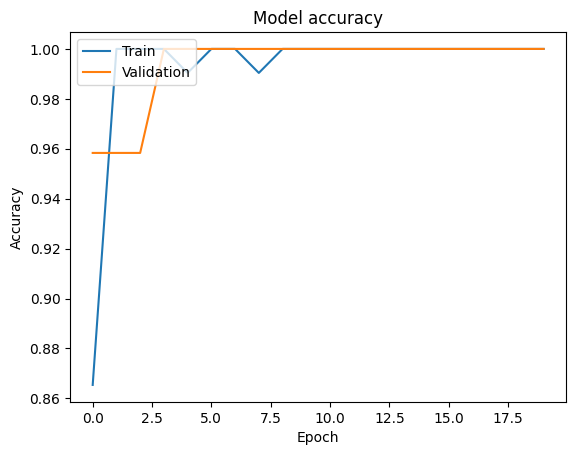

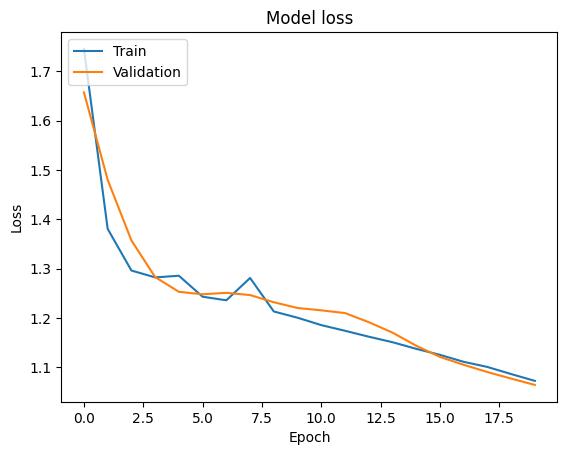

1/1 [==============================] - 3s 3s/step
Accuracy: 0.5
Precisions: [0.5 0.5]
F1 Score: [0.5 0.5]


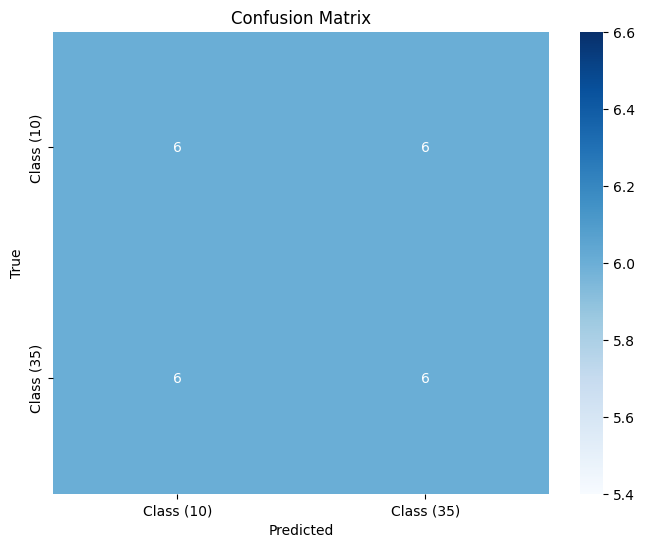

1/1 [==============================] - 2s 2s/step - loss: 1.0644 - accuracy: 1.0000
Test Loss: 1.0644
Validation Accuracy: 100.00%


In [10]:
# Load ResNet50 model with imagenet weights
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

# Create and train the model
model, hist = create_model_train_print_hist(resnet_model, 'resnet50_sigmoid', d1_train_ds, d1_val_ds)